# Predicting Heart Disease using Several Common Risk Factors
### DSCI 100 Project 
Christopher Simms 59032219

Juhi Grover 76008424

Etan Huang 29998721

Wendy Wang 38122164

### Introduction

Heart disease refers to various conditions that affect the heart, including blood vessel disease, irregular heartbeats, heart valve disease, etc. It is responsible for 1 in 4 deaths worldwide across all races and genders, making it one of the major causes of death. Heart disease is sometimes referred to as “silent” because, in many cases, it is not diagnosed until the individual experiences signs or symptoms of a heart attack or heart failure. Since it is difficult to diagnose heart disease before more severe symptoms start to appear, our goal is to predict heart disease diagnosis based on known risk factors like high blood pressure and high cholesterol, so that heart disease can be caught even before symptoms start to appear.

The dataset we are using is a Heart Disease Data Set (Janosi et al.) that contains information about a person's age, sex, other medical factors and whether the individual was diagnosed with heart disease. The dataset contains 13 variables for which observations were collected and a diagnosis column which is the categorical class we are predicting.


### Preliminary Exploratory Data Analysis

In [11]:
#run this cell before continuing
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

Reading Data from Website:

In [20]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_disease_import <- read_csv(url, 
                               col_names=c("age",
                                           "sex",
                                           "chest_pain_type",
                                           "resting_blood_pressure",
                                           "cholesterol_level",
                                           "high_fasting_blood_sugar",
                                           "resting_ecg_results",
                                           "max_heart_rate",
                                           "exercise_induced_angina",
                                           "ST_depression_induced_by_exercise",
                                           "slope_of_peak_exercise_ST_segment",
                                           "num_blood_vessels_colored",
                                           "thal",
                                           "diagnosis_old"))

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): num_blood_vessels_colored, thal
dbl (12): age, sex, chest_pain_type, resting_blood_pressure, cholesterol_lev...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Wrangling Data: 

In [22]:
# NOTE: we add a second diagnosis column here, as the one included with the dataset has values 0-4, 
#       indicating the severity of the heart disease, but the researchers who created the dataset note 
#       on their website that they only used the predictors to look for presence of heart disease, not to specify severity.
#       This new diagnosis column contains only zeroes and ones, indicating presence or absence of heart disease.

mutated_heart_disease <- heart_disease_import|>
                        mutate(sex = as_factor(sex)) |>
                        mutate(chest_pain_type = as_factor(chest_pain_type)) |>
                        mutate(high_fasting_blood_sugar = as_factor(high_fasting_blood_sugar)) |>
                        mutate(resting_ecg_results = as_factor(resting_ecg_results)) |>
                        mutate(exercise_induced_angina = as_factor(exercise_induced_angina)) |>
                        mutate(slope_of_peak_exercise_ST_segment = as_factor(slope_of_peak_exercise_ST_segment)) |>
                        mutate(num_blood_vessels_colored = as_factor(num_blood_vessels_colored)) |>
                        mutate(thal = as_factor(thal))

heart_disease_data <- mutated_heart_disease |>
                mutate(diagnosis= ifelse(diagnosis_old>0,1,0)) |>
                mutate(diagnosis_old = as_factor(diagnosis_old)) |>
                mutate(diagnosis = as_factor(diagnosis))

heart_disease_data

age,sex,chest_pain_type,resting_blood_pressure,cholesterol_level,high_fasting_blood_sugar,resting_ecg_results,max_heart_rate,exercise_induced_angina,ST_depression_induced_by_exercise,slope_of_peak_exercise_ST_segment,num_blood_vessels_colored,thal,diagnosis_old,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2,1
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3,1
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0,0


Splitting Data/Selecting Training Variables:

In [23]:
heart_disease_selected <- heart_disease_data |>
                        select(age, resting_blood_pressure, cholesterol_level, max_heart_rate, diagnosis)

heart_split <- initial_split(heart_disease_selected, prop = 0.75, strata = diagnosis)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

### Exploratory Data Analysis & Visualization

In [30]:
diagnosis_count <- heart_training |>
    group_by(diagnosis) |>
    summarize(n = n()) |>
    arrange(desc(n))

mean_diagnosis <- heart_training |>
    group_by(diagnosis) |>
    summarize(mean_age = mean(age, na.rm = TRUE), 
              mean_heart_rate = mean(max_heart_rate, na.rm = TRUE), 
              mean_cholesterol_level = mean(cholesterol_level, na.rm = TRUE),
              mean_blood_pressure = mean(resting_blood_pressure, na.rm = TRUE)) |>
    pivot_longer(cols = mean_age:mean_blood_pressure,
                 names_to = "category",
                 values_to = "mean value") |>
    pivot_wider(names_from = "diagnosis",
                values_from = "mean value")


diagnosis_count
mean_diagnosis

diagnosis,n
<fct>,<int>
0,123
1,104


category,0,1
<chr>,<dbl>,<dbl>
mean_age,52.8374,56.52885
mean_heart_rate,158.7561,139.53846
mean_cholesterol_level,239.4553,251.88462
mean_blood_pressure,128.9593,134.36538


Above are two tables, one shows the proportion of data points (people in our case) with heart disease and without. The other shows the mean values of our predictor variables for those with and without heart disease. We can see that the distribution of the target class (diagnosis) is fairly equal, so oversampling will likely not be necessary in this case. 

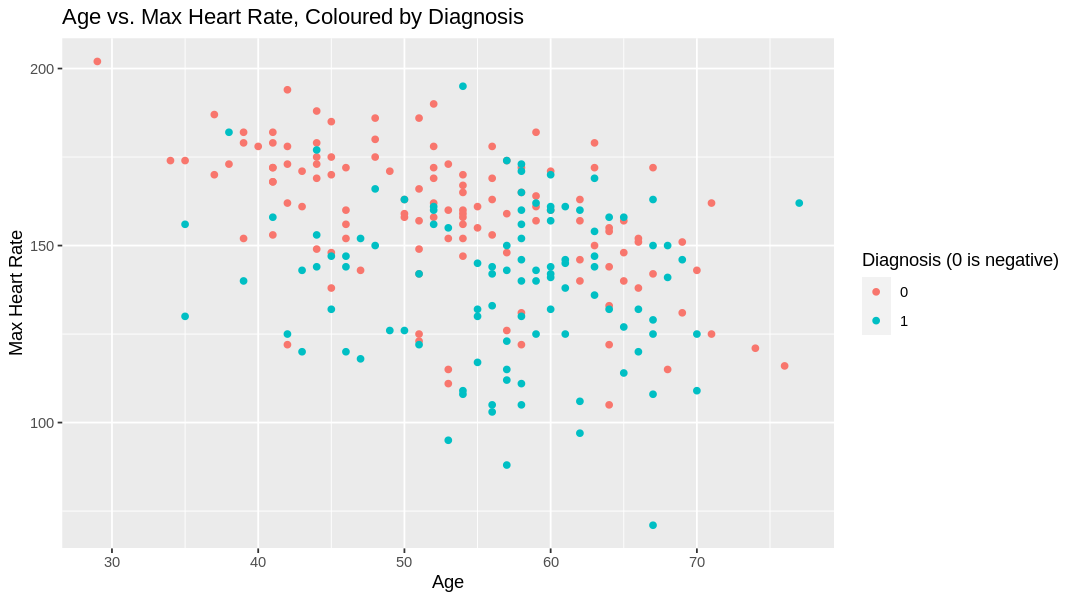

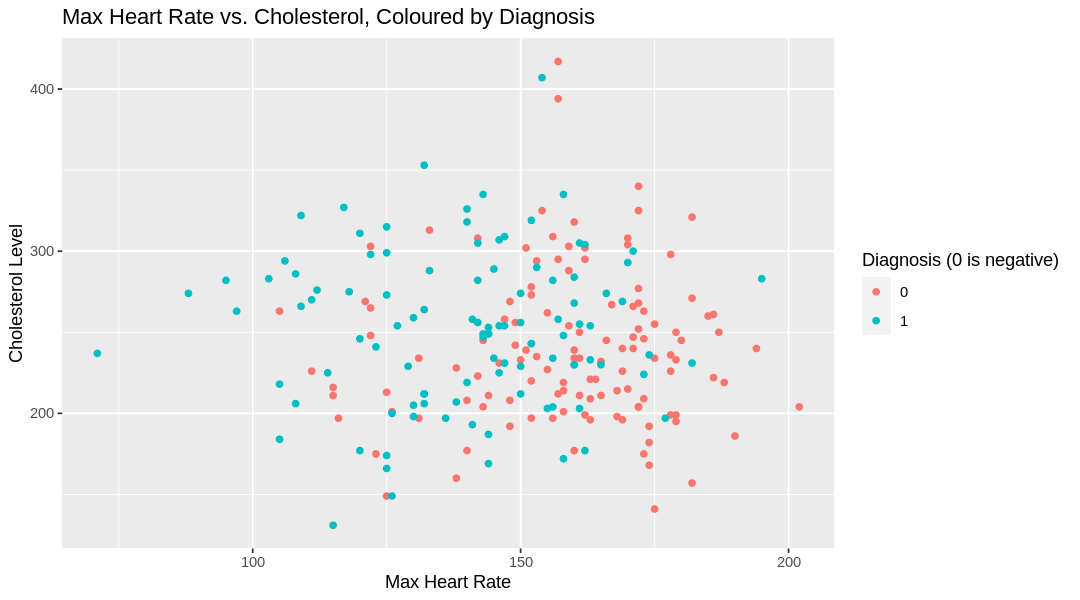

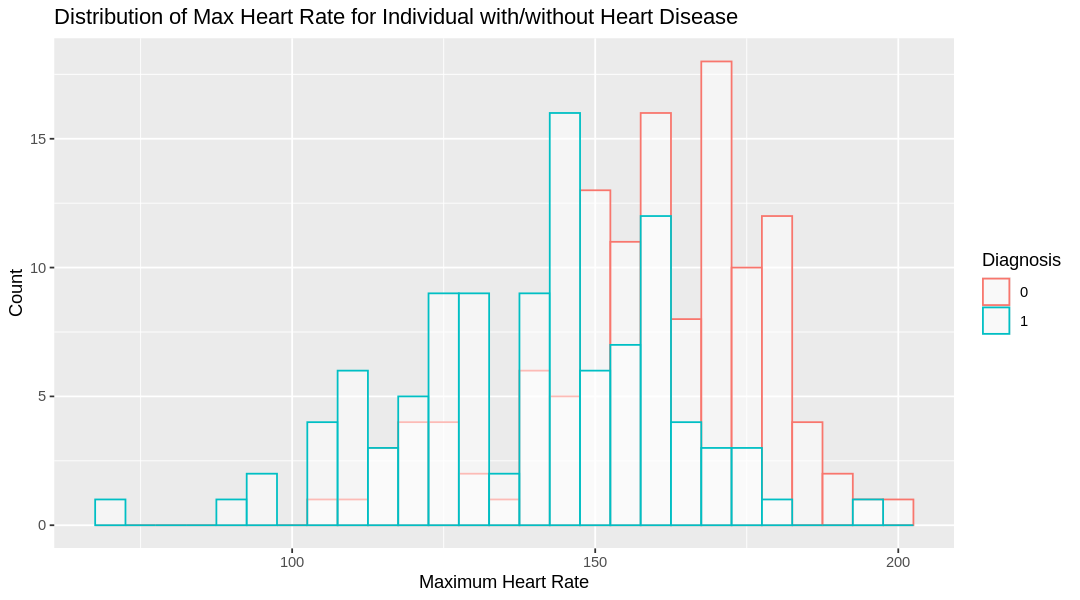

In [35]:
options(repr.plot.width=9,repr.plot.height=5)

heart_plot <- heart_training |>
            ggplot(aes(x=age,y=max_heart_rate,color=diagnosis)) +
            geom_point() +
            ggtitle("Age vs. Max Heart Rate, Coloured by Diagnosis") +
            labs(x="Age",
                 y="Max Heart Rate",
                 color="Diagnosis (0 is negative)")

cholesterol_plot <- heart_training |>
            ggplot(aes(x=max_heart_rate,y=cholesterol_level,color=diagnosis)) +
            geom_point() +
            ggtitle("Max Heart Rate vs. Cholesterol, Coloured by Diagnosis") +
            labs(x="Max Heart Rate",
                 y="Cholesterol Level",
                 color="Diagnosis (0 is negative)")

hr_distribution_plot <- ggplot(heart_training, aes(x=max_heart_rate, color = diagnosis)) +
    geom_histogram(fill="white", alpha=0.5, position="identity", binwidth=5) +
    labs(x= "Maximum Heart Rate",y="Count", color = "Diagnosis") +
    ggtitle("Distribution of Max Heart Rate for Individual with/without Heart Disease")


heart_plot
cholesterol_plot
hr_distribution_plot

Above are three plots, two scatter plots, comparing distributions of predictor variables, and one overlaid bar plot, showing the distribution of heart rates of our training data.

### Methods

Out of the 13 variables in our dataset, five were numerical. We chose to use four of these five: age, max heart rate, resting blood pressure and cholesterol levels. The fifth, which looks at ST wave depressions caused by exercise, was omitted because it is too complex for our needs, and correctly interpreting its meaning requires significant understanding of the biology of the heart.

In order to predict the presence of heart disease, we will use a classification model, trained on the four predictor variables mentioned above. One way we plan to visualize the results is using scatter plots comparing two predictors, with data points colored by diagnosis, and a background color indicating the prediction of the classifier (end of section 5.8 in the textbook).


### Expected Outcomes and Significance

We expect to find a relationship between our age, maximum heart rate, cholesterol level & blood pressure, and the diagnosis of heart disease. We hypothesize that we will be able to accurately predict if someone has heart disease based on specific values of these variables. Heart disease is one of the leading causes of mortality around the world. Being able to predict if someone has heart disease accurately is important because it can allow us to diagnose heart disease early and prevent life threats. Clinicians will be able to give treatment without any serious effects. Our findings can also tell us what factors are correlated with heart disease and, upon further research,  how we can adjust our lifestyle to prevent severe illness. 

Our analysis can lead to several questions, such as:
- How strongly are our variables related to heart disease? Does one variable have a greater impact on the prevalence of heart disease than another? 
- What are the optimal ranges for blood pressure and cholesterol levels (at each age range) to prevent heart disease?
- Are there any confounding variables that could be affecting our findings? 
- How can our findings be extended to individuals in other parts of the world? Would geographic location impact the accuracy of our model?
- How do genetics play a role in the diagnosis of heart disease? 
